In [20]:
import os
# need to run this because of memory leak in windows
os.environ["OMP_NUM_THREADS"] = "1"

In [21]:
import pandas as pd
from itertools import product
import sklearn
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import plotly.graph_objs as go
import seaborn as sns
import warnings
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import joblib

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [22]:
warnings.simplefilter(action='ignore', category=FutureWarning)

In [23]:
DATA_PATH = '../data/'
df = pd.read_csv(DATA_PATH + 'Mall_Customers.csv')

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


Removing the CustomerID as this information is not relevant for clustering

In [25]:
df = df.drop('CustomerID', axis=1)

In [26]:
df.head(5)

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


Creating the pipeline

In [27]:
def pipe_func(df, scaler, cluster):
    # Pipeline for numeric columns
    numeric_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),  # Handle missing values if any
        ('scaler', scaler)  # Standardize to mean=0, std=1
    ])

    # Pipeline for categorical columns
    categorical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),  # Handle missing values if any
        ('binary', (OneHotEncoder(drop='if_binary')))
    ])

    # Combine both pipelines using ColumnTransformer
    preprocessor = ColumnTransformer(
        [
            ('numeric', numeric_pipeline, selector(dtype_exclude="object")),
            ('categorical', categorical_pipeline, selector(dtype_include="object")),
        ],
        verbose_feature_names_out=False
    )

    # Create pca pipeline
    pca = Pipeline([
        ('preprocessor', preprocessor),
        ('pca', PCA(n_components=3, random_state=RANDOM_STATE))
    ])
    
    # Create final pipeline
    pipe = Pipeline(
        [
            ('processed_features', pca),
            ('clustering', cluster)
        ]
    )

    pipe.fit(df)

    pred_labels = pipe.named_steps['clustering'].labels_
    inertia = pipe.named_steps['clustering'].inertia_
    sil_score = silhouette_score(pipe.named_steps['processed_features'].transform(df), labels=pred_labels)

    return pipe, inertia, sil_score

In [28]:
scaler_opts = {
    # 'passthrough': 'passthrough',
    'standard': StandardScaler(), 
    'minMax': MinMaxScaler(feature_range=(-1,1)),
    'robust': RobustScaler()
}

number_of_clusters = np.arange(2, 10).tolist()

clustering_alg = {
    f'Kmeans_{value}': KMeans(value, n_init='auto', random_state=RANDOM_STATE) for value in number_of_clusters 
}


cart_prod_hyperparam = list(product(list(scaler_opts.keys()), list(clustering_alg.keys())))

inertia_vals = []
sil_vals = []

for scaler, cluster in cart_prod_hyperparam:
    pipe, inertia, sil_score = pipe_func(df=df, scaler=scaler_opts[scaler], cluster=clustering_alg[cluster])
    inertia_vals.append(inertia)
    sil_vals.append(sil_score)

In [29]:
results = pd.DataFrame(
    {
        "Scaler": [scaler for scaler, _ in cart_prod_hyperparam],
        "Cluster": [cluster for _, cluster in cart_prod_hyperparam],
        "Inertia": inertia_vals,
        "Silhouette": sil_vals
    }
)
results = results.melt(id_vars=['Scaler', 'Cluster'], value_vars=['Inertia', 'Silhouette'], var_name='Measure', value_name='Value')
results['Number of Clusters'] = results['Cluster'].apply(lambda x: x.split('_')[1])
results.head(5)

,Scaler,Cluster,Measure,Value,Number of Clusters
0,standard,Kmeans_2,Inertia,389.816186,2
1,standard,Kmeans_3,Inertia,296.124136,3
2,standard,Kmeans_4,Inertia,205.683744,4
3,standard,Kmeans_5,Inertia,168.673822,5
4,standard,Kmeans_6,Inertia,157.762036,6


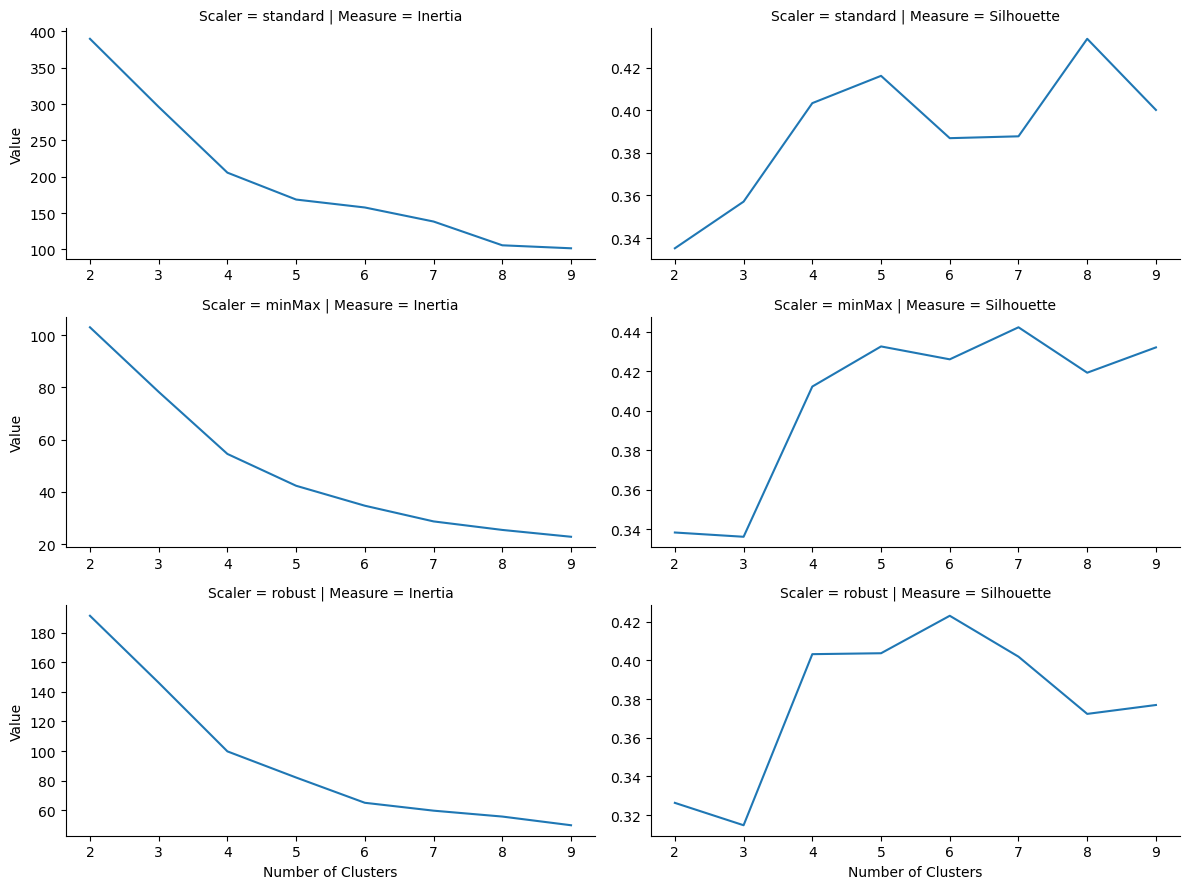

In [30]:
sns.relplot(
    data=results, x="Number of Clusters", y="Value", col="Measure",
    row="Scaler", kind="line", facet_kws={"sharey": False, "sharex": False},
    height=3, aspect=2
);

Depending on the scale technique the number of clusters will change.

- If using Standard scaler, the number of clusters might be 8 (or 5?)
- If using the MinMax scaler, the number of clusters would be 6
- And if using the Robust scaler, the number of clusters would be 6

As seen in the exploratory data analysis, a starting point was 5 clusters. But using the robust scaler as there were some outliers, I'm going to consider 6 clusters for subsequent analysis.

In [31]:
pipe, _, _ = pipe_func(df, RobustScaler(), cluster=KMeans(n_clusters=6))

df_with_label =  pd.DataFrame(pipe.named_steps['processed_features'].transform(df), columns = pipe.named_steps['processed_features'].get_feature_names_out())
df_with_label['label'] = pipe.named_steps['clustering'].labels_
df_with_label.head(5)

,pca0,pca1,pca2,label
0,-0.396602,-1.222923,0.886938,2
1,-1.071812,-1.263034,0.017872,2
2,0.151609,-1.239214,1.484344,5
3,-1.003489,-1.307731,0.028066,2
4,-0.059971,-1.226931,0.464117,5


In [38]:
colormap = matplotlib.colormaps['viridis']  # Replace 'viridis' with any other colormap
# Define the number of categories
number_of_clusters = len(df_with_label['label'].unique())
# Extract discrete colors from the colormap based on the number of clusters
discrete_colors = [matplotlib.colors.rgb2hex(colormap(i)[:3]) for i in np.linspace(0, 1, number_of_clusters)]

# Define the tick values and labels for the colorbar
tickvals = list(range(number_of_clusters))
ticktext = [f'Cluster {label}' for label in tickvals]

cluster_centroids = pipe.named_steps['clustering'].cluster_centers_

# defining scatter plot trace
trace = go.Scatter3d(
    x=df_with_label['pca0'],
    y=df_with_label['pca1'],
    z=df_with_label['pca2'],
    mode='markers',
    showlegend=False,
    name=None,
    marker=dict(
        color=df_with_label['label'],  # Color based on the specified column
        colorscale=discrete_colors,  # Choose the colorscale
        colorbar=dict(title='Cluster', tickvals=tickvals, ticktext=ticktext),
        size=5
    )
)

# defining lineplots beginning at each sample to the center of each sample cluster
lines = []
for cluster_number in range(number_of_clusters):
    df_with_label_temp = df_with_label[df_with_label['label']==cluster_number].reset_index()
    x_cen, y_cen, z_cen = cluster_centroids[cluster_number]
    for i in range(len(df_with_label_temp)):
        line = go.Scatter3d(
            x=[df_with_label_temp['pca0'][i], x_cen],
            y=[df_with_label_temp['pca1'][i], y_cen],
            z=[df_with_label_temp['pca2'][i], z_cen],
            mode='lines',
            showlegend=False,
            name=None,
            line=dict(
                color=discrete_colors[cluster_number],  # setting line color to be the same for each points within the cluster
                width=3
            )
        )
        lines.append(line)


# Create a layout
layout = go.Layout(
    width=1200,  # Adjust the width as needed
    height=1000,  # Adjust the height as needed
    scene=dict(
        xaxis=dict(title='pca0'),  # Modify the x-axis label
        yaxis=dict(title='pca1'),  # Modify the y-axis label
        zaxis=dict(title='pca2')  # Modify the z-axis label
    )
)

# Create a figure
fig = go.Figure(data=[trace] + lines, layout=layout)
fig.update_layout(
    title="3D Scatter Plot with Cluster Centroids"
)
# Display the plot
fig.show()

In [39]:
fig.write_html("../reports/3d_scatter_plot_with_cluster_centroids.html")

After inspection, we can see that the 6 clusters are well separated.

In [33]:
pca_results = pd.DataFrame(pipe.named_steps['processed_features'].named_steps['pca'].components_, columns=df.columns)
pca_results['Explained Variance'] = pipe.named_steps['processed_features'].named_steps['pca'].explained_variance_
pca_results['Explained Variance Ratio'] = pipe.named_steps['processed_features'].named_steps['pca'].explained_variance_ratio_
pca_results.index = [f'pca{i}' for i in range(pipe.named_steps['processed_features'].named_steps['pca'].n_components_)]
pca_results = pca_results.reset_index(names='Components')
pca_results

,Components,Gender,Age,Annual Income (k$),Spending Score (1-100),Explained Variance,Explained Variance Ratio
0,pca0,0.726771,-0.060704,-0.680294,0.072936,0.621123,0.365993
1,pca1,0.037745,0.995290,-0.039925,0.079868,0.518992,0.305813
2,pca2,-0.683441,-0.003249,-0.729997,-0.001444,0.313100,0.184492


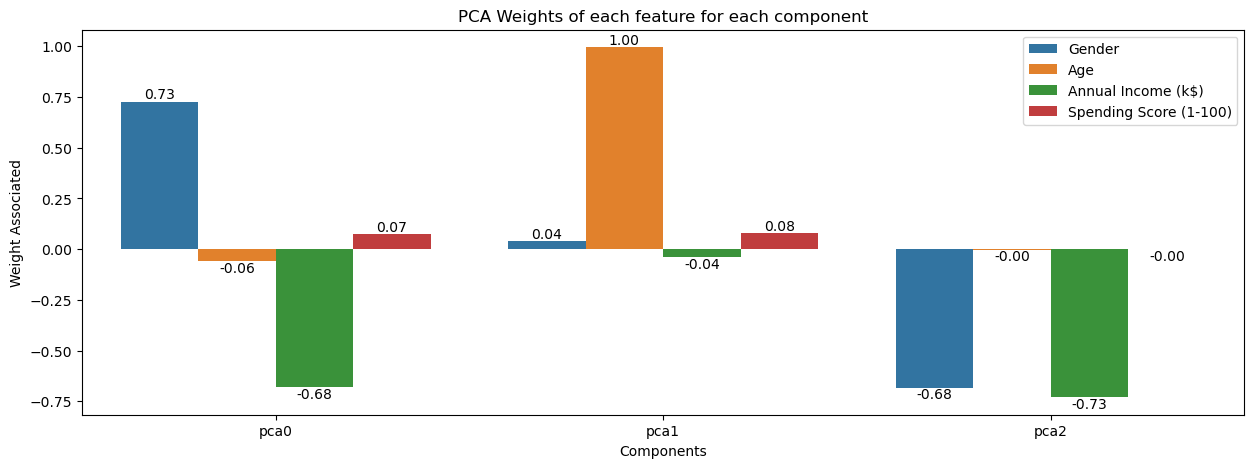

In [34]:
pca_results_pivoted = pca_results.melt(id_vars=['Components'], value_vars=df.columns.tolist(), var_name='Feature', value_name='Weight Associated')

fig, ax = plt.subplots(figsize=(15,5))
sns.barplot(data=pca_results_pivoted, x='Components', y='Weight Associated', hue='Feature')
ax.set(title='PCA Weights of each feature for each component')
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f')
ax.legend(loc='upper right')
plt.show()

Importance of each feature to the pca components:
- pca0: Gender and Annual Income (k$) are the most important features for this component, with small weight for other features. Gender with a positive correlation and Annual Income (k$) with a negative correlation.
- pca1: Age is the most important feature alone, while other features have little importance.
- pca2: again for component pca2, Gender and Annual Income (k$) are the most important features while the Age and Spending Score (1-100) have no influence at all. But this time both Gender and Annual Income (k$) are negatively correlated to the pca2 component.

In [35]:
df['Cluster'] = pipe.named_steps['clustering'].labels_
df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100),Cluster
0,Male,19,15,39,2
1,Male,21,15,81,2
2,Female,20,16,6,5
3,Female,23,16,77,2
4,Female,31,17,40,5


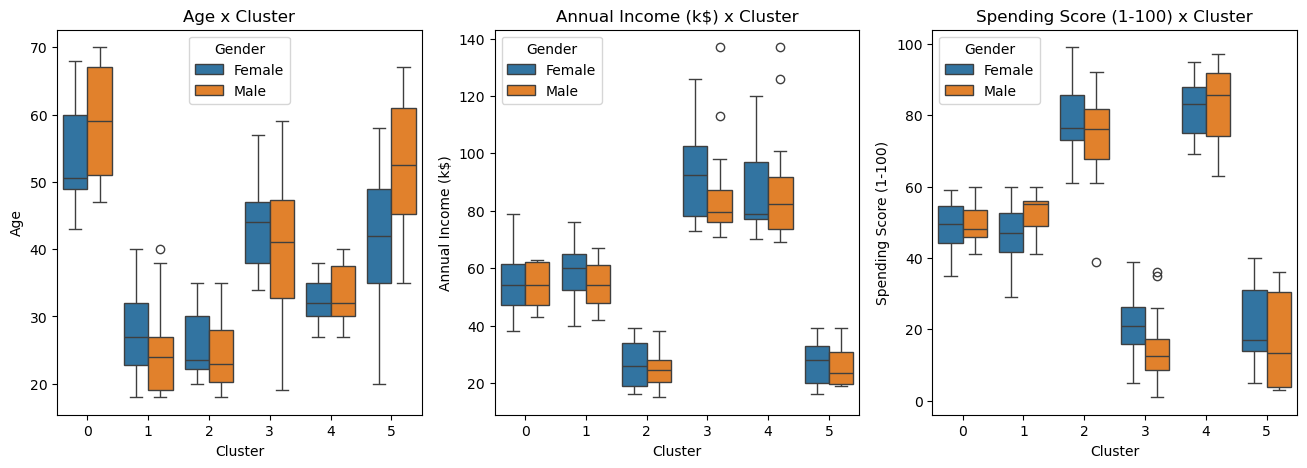

In [41]:
fig, axs = plt.subplots(ncols=3, figsize=(16,5))

for ax, col in zip(axs, df.select_dtypes('number')):
    sns.boxplot(data=df, x='Cluster', y=col, hue='Gender', ax=ax)
    ax.set_title(f'{col} x Cluster')

plt.show()

Defining personas: 
- Cluster 0: elder, average income, average spending score
- Cluster 1: young, average income, average spending score
- Cluster 2: young, small income, high spending score
- Cluster 3: middle age (around 40~45, for mens a bigger variation), high income, small spending score
- Cluster 4: middle age (around 30), high income, high spending score
- Cluster 5: mostly elder men (middle age female with some variation), small income, small spending score


In [37]:
# saving the pipeline model
joblib.dump(pipe, "../models/pipeline_model_pca.pkl")

['../models/pipeline_model_pca.pkl']